In [19]:
import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd
import os.path 
import math 
import cv2


from modules import voiddetect as vd
from modules import select_voidboundaries as sel
from modules import calcs_all as calcs
from modules import conversions as convs

In [20]:
# Column 1-3:   right hand average orientation (phi1, PHI, phi2 in radians)
# Column 4-6:   left hand average orientation (phi1, PHI, phi2 in radians)
# Column 7:     Misorientation Angle
# Column 8-10:  Misorientation Axis in Right Hand grain
# Column 11-13: Misorientation Axis in Left Hand grain
# Column 14:    length (in microns)
# Column 15:    trace angle (in degrees)
# Column 16-19: x,y coordinates of endpoints (in microns)
# Column 20-21: IDs of right hand and left hand grains

inputs = ['1_001', '1_002', '1_003', '1_004', '1_005', '1_006', '1_007', '1_008', '1_009', '1_010',
          '2_001', '2_002', '2_003', '2_004', '2_005', '2_006', '2_007', '2_008', '2_009',
          '3_001', '3_002', '3_003', '3_004', '3_005', '3_006', '3_007', '3_008', '3_009', '3_010',
          '4_001', '4_002', '4_003', '4_004', '4_005', '4_007', '4_008', '4_009',
          '5_001', '5_002', '5_003', '5_004', '5_005', '5_006', '5_007', '5_008', '5_009', '5_010', '5_011',
          '6_001', '6_002', '6_003', '6_004', '6_005', '6_006', '6_007', '6_008', '6_009', '6_010']

#inputs= ['1_001']

for name in inputs:
    print(name)
    lattice = 'bcc'
    # lattice = raw_input("\n\nCrystal Structure\nIndicate crystal structure.\nType one of the options fcc/bcc/hcp as shown: ")

    ### get current directory
    pa_current = os.getcwd()
    pa_parent = os.path.dirname(pa_current)

    # define paths for convenience
    pa_pic = pa_current + '/pyinputs/' + name + '.jpg'
    pa_txt = pa_current + '/pyinputs/' + name + '.txt'
    pa_selected = pa_current + '/saboutputs/' + name + '/' + 'selected.txt'

    ### Read data from text file
    gbdata = np.genfromtxt(pa_txt)
    selected_data = np.genfromtxt(pa_selected)
    width = np.amax(gbdata[:, 17])
    height = np.amax(gbdata[:, 18])
    
    ### Starting points
    staptsx = gbdata[:, 15]
    staptsy = gbdata[:, 16]
    #### Ending points
    endptsx = gbdata[:, 17]
    endptsy = gbdata[:, 18]
    mis_angle = gbdata[:,6]
    trace=gbdata[:,14]
    #### Euler values
    eul1 = gbdata[:,(0,1,2)]
    eul2 = gbdata[:,(3,4,5)]
    
    

    
    
    # Find dimensions for picture
    width = np.amax(gbdata[:, 17])
    height = np.amax(gbdata[:, 18])
    # Column 20-21: IDs of right hand and left hand grains
    lhgrain=gbdata[:, 19]
    rhgrain=gbdata[:, 20]    
        
    # define maximum void area as a multiple of average grain size (last number is factor of multiplication)
    maxarea = width * height / np.amax(gbdata[:, 20]) * 2.5

    ### run voiddetect module and return centers and radii of detected voids
    centers, radii, vheight, voidimage, drawing = vd.findvoid(pa_pic, name, maxarea)

    ### Select boundaries in void vicinity
    selected = sel.selgb(gbdata, centers, radii)
    break

1_001


In [14]:
def rot2eul(R):
    beta = -np.arcsin(R[2,0])
    alpha = np.arctan2(R[2,1]/np.cos(beta),R[2,2]/np.cos(beta))
    gamma = np.arctan2(R[1,0]/np.cos(beta),R[0,0]/np.cos(beta))
    return np.array((alpha, beta, gamma))

def eul2rot(theta):
    R = np.array([[np.cos(theta[1])*np.cos(theta[2]),       np.sin(theta[0])*np.sin(theta[1])*np.cos(theta[2]) - np.sin(theta[2])*np.cos(theta[0]),      np.sin(theta[1])*np.cos(theta[0])*np.cos(theta[2]) + np.sin(theta[0])*np.sin(theta[2])],
                  [np.sin(theta[2])*np.cos(theta[1]),       np.sin(theta[0])*np.sin(theta[1])*np.sin(theta[2]) + np.cos(theta[0])*np.cos(theta[2]),      np.sin(theta[1])*np.sin(theta[2])*np.cos(theta[0]) - np.sin(theta[0])*np.cos(theta[2])],
                  [-np.sin(theta[1]),                        np.sin(theta[0])*np.cos(theta[1]),                                                           np.cos(theta[0])*np.cos(theta[1])]])

    return R

def eul2orient(theta): #Radians
    g = np.array([[np.cos(theta[0])*np.cos(theta[2])-np.sin(theta[0])*np.sin(theta[2])*np.cos(theta[1]), np.sin(theta[0])*np.cos(theta[2])+np.cos(theta[0])*np.sin(theta[2])*np.cos(theta[1]), np.sin(theta[2])*np.sin(theta[1])],
                  [(-1)*np.cos(theta[0])*np.sin(theta[2])-np.sin(theta[0])*np.cos(theta[2])*np.cos(theta[1]), (-1)*np.sin(theta[0])*np.sin(theta[2])+np.cos(theta[0])*np.cos(theta[2])*np.cos(theta[1]), np.cos(theta[2])*np.sin(theta[1])],
                  [np.sin(theta[0])*np.cos(theta[1]), -np.cos(theta[0])*np.sin(theta[1]), np.cos(theta[1])]])

    return g

def orientation_matrix(euler1,euler2): #Radians
    g_1=eul2orient(euler1)
    g_2=eul2orient(euler2)
    orientation_matrix=np.dot(g_1,np.linalg.inv(g_2))
    return orientation_matrix

def misorientation_angle(orientation_matrix):
    cos_mori=(orientation_matrix[0][0]+orientation_matrix[1][1]+orientation_matrix[2][2]-1)/2 #Degrees
    misorientation_angle=np.arccos(cos_mori)
    misorientation_angle=np.degrees(misorientation_angle)   
    return misorientation_angle

def misorientation_angle_2(R1): # From Sabines Code
    misang1 = np.arccos(0.5*(R1[0,0]+R1[1,1]+R1[2,2]-1))
    
    p1 = (R1[2,1]-R1[1,2])/(2*np.sin(misang1))
    p2 = (R1[0,2]-R1[2,0])/(2*np.sin(misang1))
    p3 = (R1[1,0]-R1[0,1])/(2*np.sin(misang1))

    ax = [p1,p2,p3]
    ang = misang1
    ax = ax/np.linalg.norm(ax)
    ang=np.degrees(ang)
    return ang, ax

def eu2qu(Eul):
    
    P = -1
    
    o = (Eul[0]+Eul[2])/2 
    d = (Eul[0]-Eul[2])/2
    c = np.cos(Eul[1]/2)
    s = np.sin(Eul[1]/2)
    q = [c*np.cos(o), -P*s*np.cos(d), -P*s*np.sin(d), -P*c*np.sin(o)]

    if c*np.cos(o) <0:
        q = [-c*np.cos(o), P*s*np.cos(d), P*s*np.sin(d), P*c*np.sin(o)]

    else:
        q = [c*np.cos(o), -P*s*np.cos(d), -P*s*np.sin(d), -P*c*np.sin(o)]
    return q 

def ax2qu(ax, ang):
    q = [np.cos(ang/2), np.sin(ang/2)*ax[0], np.sin(ang/2)*ax[1], np.sin(ang/2)*ax[2]]
    
    return q

In [15]:
misor=[]
misor_2=[]

for i,euler in enumerate(eul1):
    m_orientation=orientation_matrix(eul1[i],eul2[i])
    misor_angle=misorientation_angle(m_orientation)
    misor.append(misor_angle)


#for i,euler in enumerate(eul1):
    #m_orientation=orientation_matrix(eul1[i],eul2[i])
    #misorientation_angle(m_orientation)
    #misor_angle=misorientation_angle(m_orientation)
    #if misor_angle >= 60:
        #m_orientation=orientation_matrix(eul2[i],eul1[i])
        #misor_angle=misorientation_angle(m_orientation)
    #misor_2.append(misorientation_angle_2(m_orientation))

<ipython-input-14-9d8f2965eed9>:29: RuntimeWarning: invalid value encountered in arccos
  misorientation_angle=np.arccos(cos_mori)


<ipython-input-16-b8a4cfcb04ec>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = plt.axes()


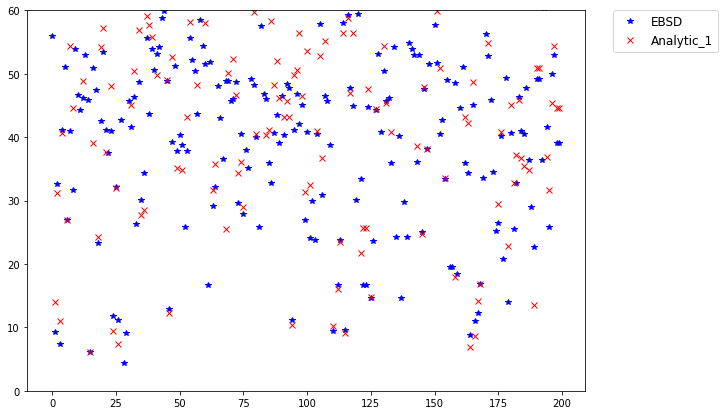

In [16]:
plt.figure(figsize=(10,7))
plt.plot(mis_angle[:200],'b*',label='EBSD')
plt.plot(misor[:200],'rx',label='Analytic_1')
axes = plt.axes()
axes.set_ylim([0, 60])
plt.legend(bbox_to_anchor=(1.05, 1), prop={'size': 12}, loc='upper left', borderaxespad=0.)
#plt.savefig('Misorientation.png' , bbox_inches='tight')

In [17]:
# Error Value, less than 60 degrees
error=[]

for i ,angle in enumerate(misor):
    if angle<60:
        er=(abs(mis_angle[i]-angle)/mis_angle[i])*100
        error.append(er)
print(np.average(error))

18.686525853721275


In [76]:
### Find trace angle with respect to shock loading. For data I've got from Veronica
### so far, that means the shock loading is in the x-direction TSL Eulerian space. 
### Therefore, 'run' = y-axis and 'rise' = x-axis. Tan(trace)=rise/run

trace_angle=[]
for i,data in enumerate(gbdata):
    nl = [0,0]
    nl[0]=endptsx[i]-staptsx[i]
    nl[1]=endptsy[i]-staptsy[i]

    if nl[1]==0:
        inplane = np.pi
    else:
        #inplane = np.arctan(nl[1]/nl[0]) + np.pi/2
        inplane = np.pi - np.arctan(nl[1]/nl[0])
    
    if inplane < 0:
        inplane = np.pi + inplane
    if inplane > np.pi:
        inplane = inplane - np.pi
        
    ### second trace angle since out of plane is from 0 to 90.
    inplane2 = inplane + np.pi
    trace_angle.append(np.degrees(inplane))

<ipython-input-76-717b112f8403>:15: RuntimeWarning: divide by zero encountered in double_scalars
  inplane = np.pi-np.arctan(nl[1]/nl[0])


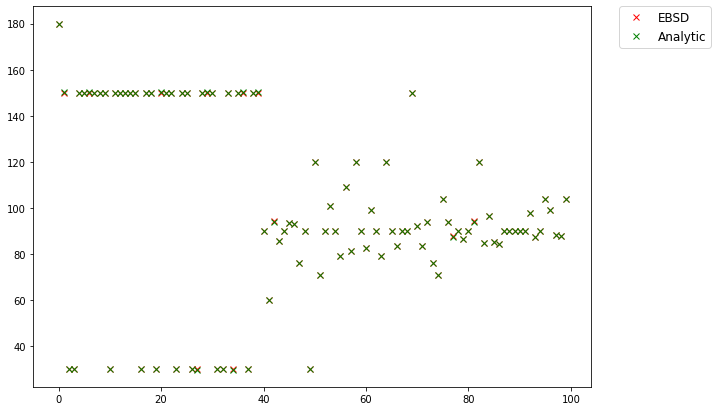

In [79]:
plt.figure(figsize=(10,7))
plt.plot(trace[:100],'rx',label='EBSD')
plt.plot(trace_angle[:100],'gx',label='Analytic')
#plt.plot(trace[:100],'bx',label='Txt')
plt.legend(bbox_to_anchor=(1.05, 1), prop={'size': 12}, loc='upper left', borderaxespad=0.)
plt.savefig('Trace.png' , bbox_inches='tight')

In [29]:
trace_round=np.round(np.array(trace_angle),1)

In [78]:
# Error Value, less than 60 degrees
error_trace=[]

for i ,trace_ang in enumerate(trace):
    if angle<60:
        er=(abs(trace_angle[i]-trace_ang)/trace_ang)*100
        error_trace.append(er)
print(np.average(error_trace))

0.08682603378047835


In [72]:
print(trace_angle[2])
print(trace[2])

59.88626684901748
30.0


In [69]:
nl = [0,0]
nl[0]=endptsx[1]-staptsx[1]
nl[1]=endptsy[1]-staptsy[1]
print(nl)
print(np.degrees(np.pi-np.arctan(nl[1]/nl[0])))

[1.0, 0.5700000000000003]
150.3168598208767
